<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/fine_tuning_llms_rlhf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine tuning LLMs using RLHF

## Install required libraries

In [2]:
%%bash
pip install -q transformers
pip install -q sentencepiece
pip install -q datasets
pip install -q tokenizers
pip install -q evaluate
pip install -q rouge_score
pip install -q nltk
pip install -q accelerate
pip install -q peft
pip install -q trl

ERROR: azureml-automl-dnn-nlp 1.51.0 has requirement datasets<=2.3.2,>=1.7.0, but you'll have datasets 2.11.0 which is incompatible.
ERROR: azureml-automl-dnn-nlp 1.51.0 has requirement torch<=1.12.0,>=1.5.0, but you'll have torch 2.2.1 which is incompatible.
ERROR: azureml-automl-dnn-nlp 1.51.0 has requirement transformers[sentencepiece]<=4.16.0, but you'll have transformers 4.39.0 which is incompatible.


## Import libraries

In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import pandas as pd
import warnings
import torch
from torch import nn
import nltk
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
warnings.filterwarnings('ignore')
from transformers.models.blip_2.modeling_blip_2 import AutoModelForSeq2SeqLM
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")


2024-03-22 10:59:36.986739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 10:59:37.124981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-22 10:59:37.125003: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-22 10:59:37.909790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Using cuda device


## Load and test the classifier

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

classifier_logits_kwargs = {
    "top_k": None,
    "return_all_scores" : True,
    "function_to_apply": "none",
    "batch_size": 16
}
classifier_probs_kwargs = {
    "top_k": None,
    "return_all_scores" : True,
    "function_to_apply": "softmax",
    "batch_size": 16
}
classifier = "lvwerra/distilbert-imdb"
tokenizer = AutoTokenizer.from_pretrained(classifier)
classifier = pipeline('sentiment-analysis', model=classifier, tokenizer=tokenizer) # cuda = 0,1 based on gpu availability

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [3]:
classifier("this movie is awesome!!", **classifier_logits_kwargs)

[{'label': 'POSITIVE', 'score': 2.637155771255493},
 {'label': 'NEGATIVE', 'score': -2.3706774711608887}]

In [4]:
classifier("this movie was really bad!!",**classifier_probs_kwargs)

[{'label': 'NEGATIVE', 'score': 0.993704617023468},
 {'label': 'POSITIVE', 'score': 0.006295382510870695}]

In [5]:
def get_positive_score(classifier_output):
    if classifier_output[0]['label'] == 'POSITIVE':
        return classifier_output[0]['score']
    else:
        return classifier_output[1]['score']
get_positive_score(classifier("this movie is awesome!!", **classifier_probs_kwargs))

0.9933590292930603

In [6]:
def get_sentiment(classifier_output):
    if classifier_output[0]['label'] == 'POSITIVE':
        return 1
    else:
        return 0
get_sentiment(classifier("this movie is awesome!!", **classifier_probs_kwargs))


1

## Build Baseline Model using PEFT

In [7]:
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)

In [8]:
squad = load_dataset("squad", split="train")
squad = squad.train_test_split(test_size=0.2)
squad

Found cached dataset parquet (/home/azureuser/.cache/huggingface/datasets/parquet/plain_text-57edf78d6033ac9a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 70079
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 17520
    })
})

In [9]:
squad = squad.flatten()
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 70079
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 17520
    })
})

In [10]:
target_input_length = 512
target_max_length = 100

filtered_squad = squad.filter(lambda x: (len(x.get('context')) + len(x.get('question')) < target_input_length) and (x.get('answers.answer_start')[0]) < (target_input_length + len(x.get('answers.text'))) and len(x.get('answers.text')) > 0)
filtered_squad = filtered_squad.shuffle()
# Ablation
train_size = 1000
test_size = 300
filtered_squad['train'] = filtered_squad['train'].select(range(train_size))
filtered_squad['test'] = filtered_squad['test'].select(range(test_size))
filtered_squad

Filter:   0%|          | 0/70079 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17520 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start'],
        num_rows: 300
    })
})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


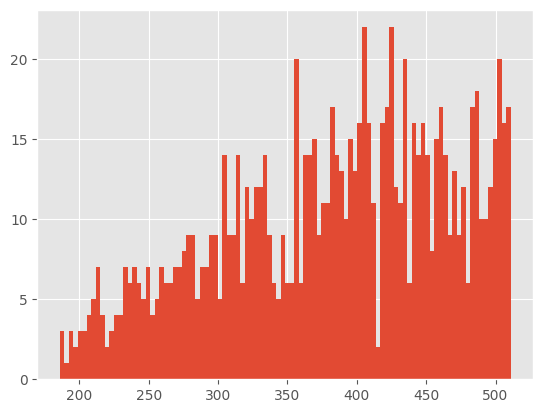

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
lengths = [len(row['context'] + row['question']) for row in filtered_squad['train']]
plt.hist(lengths, bins=100)
plt.show()

In [12]:
def preprocess_data(examples):
  """Adds prefix, tokenizes and sets the labels"""
  questions = examples["question"]
  contexts = examples["context"]
  titles = examples["title"]
  answers = []
  for answer in examples["answers.text"]:
    answers.append(answer[0])
  inputs = []
  for question, context in zip(questions, contexts):
    prefix = f"""Answer a question about this article in few sentences:\n{context}\nQ:{question}A:"""
    input = prefix.format(context=context.strip(), question=question.strip())
    inputs.append(input)
  model_inputs = tokenizer(inputs,
                           truncation='longest_first',
                           padding="max_length",
                           max_length=target_input_length,
                           return_tensors="pt")
  model_inputs = tokenizer(text=inputs,
                           max_length=target_max_length)
  model_inputs["query"] = tokenizer.batch_decode(model_inputs["input_ids"], skip_special_tokens=True)
  labels = tokenizer(text_target=answers, max_length=target_max_length, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tensored_data = filtered_squad.map(preprocess_data, remove_columns=squad["train"].column_names, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [13]:
tensored_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'query', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'query', 'labels'],
        num_rows: 300
    })
})

In [14]:
tensored_data.set_format("pt", columns=["input_ids"], output_all_columns=True)

In [15]:
df = pd.DataFrame(tensored_data['train'])
df.iloc[0]

input_ids         [tensor(11801), tensor(3), tensor(9), tensor(8...
attention_mask    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
query             Answer a question about this article in few se...
labels                                                    [1125, 1]
Name: 0, dtype: object

In [16]:
import nltk
import evaluate
nltk.download('punkt', quiet=True)

# loading Rouge
rogue_metric = evaluate.load('rouge')

In [17]:
from peft import PeftModel, PeftConfig, LoraConfig, TaskType
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType

LEARNING_RATE = 1e-3
BATCH_SIZE = 8
PER_DEVICE_EVAL_BATCH = 8
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 5

lora_config = LoraConfig(
    r=16, #Rank
    lora_alpha=32,
    target_modules=["lm_head"], # we can use layer names from model, here we are training q, v
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

peft_model = get_peft_model(model, lora_config)
peft_model = peft_model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
peft_model.print_trainable_parameters()

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

def compute_metrics(eval_preds):
   preds, labels = eval_preds
   # decode preds and labels
   labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
   decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
   decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
   # rougeLSum expects newline after each sentence
   decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
   decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
   result = rogue_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
   return result

training_args = Seq2SeqTrainingArguments(
   output_dir="./peft_results",
   learning_rate=LEARNING_RATE,
   num_train_epochs=NUM_EPOCHS,
   evaluation_strategy="epoch",
   predict_with_generate=True,
   per_device_train_batch_size=BATCH_SIZE,
   per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
   weight_decay=WEIGHT_DECAY,
   save_total_limit=SAVE_TOTAL_LIM,
   push_to_hub=False
)

trainer = Seq2SeqTrainer(
   model=peft_model,
   args=training_args,
   train_dataset=tensored_data["train"],
   eval_dataset=tensored_data["test"],
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)


trainable params: 522,240 || all params: 77,483,392 || trainable%: 0.6740025010779084


In [18]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024/03/22 11:00:14 ERROR ml

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.963944,0.560588,0.317664,0.562218,0.560178


KeyboardInterrupt: 

In [20]:
import random
for i in range(1):
  print("#####"*20)
  random_idx = random.randint(0, len(filtered_squad["train"]))
  question = filtered_squad["train"][random_idx]["question"]
  context = filtered_squad["train"][random_idx]["context"]
  title = filtered_squad["train"][random_idx]["title"]
  baseline_answer = filtered_squad["train"][random_idx]["answers.text"]
  prompt = f"""Please answer a question about the following article about {title}\n{context}\n\nQ: {question}"""
  print(prompt)
  print("====="*10)
  print("Baseline answer:")
  print(baseline_answer)
  print("====="*10)
  sentence_encoded = tokenizer(prompt, return_tensors='pt', max_length=target_input_length, truncation=True)
  peft_model = peft_model.to('cpu')
  pred_answer = peft_model.generate(input_ids=sentence_encoded['input_ids'], max_new_tokens=100)
  sentence_decoded = tokenizer.decode(pred_answer[0], skip_special_tokens=True)
  print("Generated Answer")
  print(sentence_decoded)
  print("====="*10)
  rouge_score = rogue_metric.compute(predictions=[sentence_decoded], references=[baseline_answer])
  print(rouge_score)
  print("#####"*20)

####################################################################################################
Please answer a question about the following article about Political_corruption
Political corruption is the use of powers by government officials for illegitimate private gain. An illegal act by an officeholder constitutes political corruption only if the act is directly related to their official duties, is done under color of law or involves trading in influence.

Q: Who benefits from political corruption?
Baseline answer:
['government officials']
Generated Answer
government officials
{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}
####################################################################################################


## PPO Training

In [21]:
def format_number_to_millions(number):
  return f'{number / 1_000_000:.2f}M'

def print_parameters_summary(model):
  total_params = 0
  trainable_params = 0
  params = model.parameters()
  for param in params:
      if param.requires_grad:
          trainable_params += param.numel()
      total_params += param.numel()
  return total_params, trainable_params

def print_number_of_trainable_model_parameters(model):
  total_params, trainable_params = print_parameters_summary(model)
  return f'Total model parameters: {format_number_to_millions(total_params)}' \
         f'\nTrainable model parameters: {format_number_to_millions(trainable_params)}' \
         f'\nPercentage of trainable model parameters: {round((trainable_params/total_params)*100,2)}'

In [22]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

ref_model = create_reference_model(ppo_model)

print(f'Reference model parameters:\n{print_number_of_trainable_model_parameters(ppo_model)}')
print("===="*20)
print(f'PPO model parameters to be updated:{print_number_of_trainable_model_parameters(ref_model)}')
print("===="*20)
print(ppo_model.v_head)


Reference model parameters:
Total model parameters: 77.48M
Trainable model parameters: 0.52M
Percentage of trainable model parameters: 0.67
PPO model parameters to be updated:Total model parameters: 77.48M
Trainable model parameters: 0.00M
Percentage of trainable model parameters: 0.0
ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=512, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [23]:
tensored_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'query', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'query', 'labels'],
        num_rows: 300
    })
})

In [24]:
df = pd.DataFrame(tensored_data['train'])
df.iloc[0]

input_ids         [tensor(11801), tensor(3), tensor(9), tensor(8...
attention_mask    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
query             Answer a question about this article in few se...
labels                                                    [4761, 1]
Name: 0, dtype: object

In [25]:
learning_rate=1.4e-5
max_ppo_epochs=5
mini_batch_size=8
batch_size=16
output_min_length = 10
output_max_length = 100
output_length_sampler = LengthSampler(output_min_length, output_max_length)
generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}
max_ppo_steps = 100

In [26]:
def collator(data):
    data = dict((key, [d[key] for d in data]) for key in data[0])
    return data

In [27]:
config = PPOConfig(
    model_name=model_name,
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)
ppo_trainer = PPOTrainer(config=config,
                         model=ppo_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         data_collator=collator,
                         dataset=tensored_data["train"])

In [28]:
data = ["hello world and hello moon"]
wordcount= evaluate.load("word_count")
results = wordcount.compute(data=data)
results

{'total_word_count': 5, 'unique_words': 4}

In [29]:
import tqdm

rewards_mean = []
kl_divergence = []
advantages = []

def get_rewards(responses, config):
  rewards = []
  for response in responses:
    word_count_penalty = wordcount.compute(data=[response])['total_word_count'] / output_max_length
    classifier_response = get_positive_score(classifier(response, **config))
    reward = classifier_response * word_count_penalty
    rewards.append(reward)
  return rewards

for step, batch in tqdm.tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break
    prompt_tensors = batch["input_ids"]
    # Get response from FLAN-T5/PEFT LLM.
    answer_tensors = []
    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()
        generation_kwargs["max_new_tokens"] = max_new_tokens
        answer = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        answer_tensors.append(answer.squeeze()[-max_new_tokens:])
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in answer_tensors]
    # Compute reward outputs.
    responses = [r for r in batch["response"]]
    rewards = get_rewards(responses, classifier_logits_kwargs)
    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward) for reward in rewards]
    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, answer_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)

    rewards_mean.append(stats["ppo/returns/mean"])
    kl_divergence.append(stats["objective/kl"])
    advantages.append(stats["ppo/policy/advantages_mean"])

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

1it [00:04,  4.39s/it]

objective/kl: 1.8751225471496582
ppo/returns/mean: -0.11900980770587921
ppo/policy/advantages_mean: -0.029979825019836426
---------------------------------------------------------------------------------------------------


2it [00:07,  3.83s/it]

objective/kl: 1.8694148063659668
ppo/returns/mean: -0.1779404729604721
ppo/policy/advantages_mean: 0.002354787662625313
---------------------------------------------------------------------------------------------------


3it [00:11,  3.53s/it]

objective/kl: 2.185473680496216
ppo/returns/mean: -0.25482115149497986
ppo/policy/advantages_mean: -0.0005925677833147347
---------------------------------------------------------------------------------------------------


4it [00:14,  3.48s/it]

objective/kl: 1.9930129051208496
ppo/returns/mean: -0.26188498735427856
ppo/policy/advantages_mean: 0.03935976326465607
---------------------------------------------------------------------------------------------------


5it [00:19,  3.88s/it]

objective/kl: 2.302180290222168
ppo/returns/mean: -0.25407537817955017
ppo/policy/advantages_mean: 0.018572544679045677
---------------------------------------------------------------------------------------------------


6it [00:23,  4.09s/it]

objective/kl: 3.7020530700683594
ppo/returns/mean: -0.4286651611328125
ppo/policy/advantages_mean: 0.05643508955836296
---------------------------------------------------------------------------------------------------


7it [00:28,  4.41s/it]

objective/kl: 1.6266025304794312
ppo/returns/mean: -0.20293591916561127
ppo/policy/advantages_mean: 0.035989563912153244
---------------------------------------------------------------------------------------------------


8it [00:33,  4.65s/it]

objective/kl: 2.3285577297210693
ppo/returns/mean: -0.24684511125087738
ppo/policy/advantages_mean: 0.010537105612456799
---------------------------------------------------------------------------------------------------


9it [00:36,  4.20s/it]

objective/kl: 2.2303476333618164
ppo/returns/mean: -0.25470027327537537
ppo/policy/advantages_mean: -0.0018796660006046295
---------------------------------------------------------------------------------------------------


10it [00:40,  3.91s/it]

objective/kl: 2.552926540374756
ppo/returns/mean: -0.23854830861091614
ppo/policy/advantages_mean: 0.0028066900558769703
---------------------------------------------------------------------------------------------------


11it [00:43,  3.64s/it]

objective/kl: 2.8128151893615723
ppo/returns/mean: -0.28980961441993713
ppo/policy/advantages_mean: 0.0225710179656744
---------------------------------------------------------------------------------------------------


12it [00:47,  3.91s/it]

objective/kl: 2.7744860649108887
ppo/returns/mean: -0.3060190677642822
ppo/policy/advantages_mean: -0.019812239333987236
---------------------------------------------------------------------------------------------------


13it [00:51,  3.79s/it]

objective/kl: 2.3729615211486816
ppo/returns/mean: -0.3166906535625458
ppo/policy/advantages_mean: 0.018992165103554726
---------------------------------------------------------------------------------------------------


14it [00:54,  3.68s/it]

objective/kl: 2.5502078533172607
ppo/returns/mean: -0.2543480098247528
ppo/policy/advantages_mean: -0.018786227330565453
---------------------------------------------------------------------------------------------------


15it [00:58,  3.61s/it]

objective/kl: 1.3157711029052734
ppo/returns/mean: -0.12076699733734131
ppo/policy/advantages_mean: -0.0049491203390061855
---------------------------------------------------------------------------------------------------


16it [01:03,  3.99s/it]

objective/kl: 3.6450352668762207
ppo/returns/mean: -0.504844605922699
ppo/policy/advantages_mean: 0.08871334791183472
---------------------------------------------------------------------------------------------------


17it [01:06,  3.77s/it]

objective/kl: 1.8380491733551025
ppo/returns/mean: -0.21082310378551483
ppo/policy/advantages_mean: -0.0010206521255895495
---------------------------------------------------------------------------------------------------


18it [01:09,  3.72s/it]

objective/kl: 2.7718310356140137
ppo/returns/mean: -0.25418898463249207
ppo/policy/advantages_mean: 0.016232945024967194
---------------------------------------------------------------------------------------------------


19it [01:13,  3.72s/it]

objective/kl: 1.6795361042022705
ppo/returns/mean: -0.313464492559433
ppo/policy/advantages_mean: 0.002133320551365614
---------------------------------------------------------------------------------------------------


20it [01:18,  3.95s/it]

objective/kl: 2.3864006996154785
ppo/returns/mean: -0.2583160400390625
ppo/policy/advantages_mean: 0.013511615805327892
---------------------------------------------------------------------------------------------------


21it [01:21,  3.81s/it]

objective/kl: 2.1488919258117676
ppo/returns/mean: -0.23469951748847961
ppo/policy/advantages_mean: 0.007179883774369955
---------------------------------------------------------------------------------------------------


22it [01:25,  3.78s/it]

objective/kl: 2.7064993381500244
ppo/returns/mean: -0.3693957030773163
ppo/policy/advantages_mean: 0.01620562933385372
---------------------------------------------------------------------------------------------------


23it [01:29,  4.03s/it]

objective/kl: 2.245255708694458
ppo/returns/mean: -0.2817947566509247
ppo/policy/advantages_mean: 0.013570792973041534
---------------------------------------------------------------------------------------------------


24it [01:33,  3.96s/it]

objective/kl: 7.3829851150512695
ppo/returns/mean: -1.0817779302597046
ppo/policy/advantages_mean: 0.041270434856414795
---------------------------------------------------------------------------------------------------


25it [01:38,  4.11s/it]

objective/kl: 4.096673965454102
ppo/returns/mean: -0.3106241226196289
ppo/policy/advantages_mean: -0.04854680225253105
---------------------------------------------------------------------------------------------------


26it [01:42,  4.15s/it]

objective/kl: 3.780575752258301
ppo/returns/mean: -0.4551860988140106
ppo/policy/advantages_mean: -0.007861359976232052
---------------------------------------------------------------------------------------------------


27it [01:46,  4.02s/it]

objective/kl: 1.5378004312515259
ppo/returns/mean: -0.23107662796974182
ppo/policy/advantages_mean: -0.02711949311196804
---------------------------------------------------------------------------------------------------


28it [01:49,  3.93s/it]

objective/kl: 2.0263078212738037
ppo/returns/mean: -0.2997889816761017
ppo/policy/advantages_mean: 0.018118498846888542
---------------------------------------------------------------------------------------------------


29it [01:53,  3.93s/it]

objective/kl: 2.911778450012207
ppo/returns/mean: -0.33530566096305847
ppo/policy/advantages_mean: 0.046388812363147736
---------------------------------------------------------------------------------------------------


30it [01:57,  3.99s/it]

objective/kl: 1.4454891681671143
ppo/returns/mean: -0.15828876197338104
ppo/policy/advantages_mean: 0.0136738745495677
---------------------------------------------------------------------------------------------------


31it [02:00,  3.71s/it]

objective/kl: 1.2961653470993042
ppo/returns/mean: -0.0996418371796608
ppo/policy/advantages_mean: -0.013308972120285034
---------------------------------------------------------------------------------------------------


32it [02:04,  3.68s/it]

objective/kl: 1.9173920154571533
ppo/returns/mean: -0.2818719744682312
ppo/policy/advantages_mean: 0.028752297163009644
---------------------------------------------------------------------------------------------------


33it [02:07,  3.56s/it]

objective/kl: 2.077176094055176
ppo/returns/mean: -0.28715652227401733
ppo/policy/advantages_mean: 0.035742055624723434
---------------------------------------------------------------------------------------------------


34it [02:12,  3.80s/it]

objective/kl: 2.97357177734375
ppo/returns/mean: -0.3322436213493347
ppo/policy/advantages_mean: -0.012943647801876068
---------------------------------------------------------------------------------------------------


35it [02:15,  3.61s/it]

objective/kl: 3.195189952850342
ppo/returns/mean: -0.5637354850769043
ppo/policy/advantages_mean: 0.04607628285884857
---------------------------------------------------------------------------------------------------


36it [02:18,  3.58s/it]

objective/kl: 1.7958505153656006
ppo/returns/mean: -0.19632694125175476
ppo/policy/advantages_mean: 0.0005502343410626054
---------------------------------------------------------------------------------------------------


37it [02:22,  3.56s/it]

objective/kl: 1.355931282043457
ppo/returns/mean: -0.17100895941257477
ppo/policy/advantages_mean: -0.01724090427160263
---------------------------------------------------------------------------------------------------


38it [02:27,  3.97s/it]

objective/kl: 4.370850563049316
ppo/returns/mean: -0.4764691889286041
ppo/policy/advantages_mean: 0.039908476173877716
---------------------------------------------------------------------------------------------------


39it [02:30,  3.81s/it]

objective/kl: 0.6534801125526428
ppo/returns/mean: -0.21261191368103027
ppo/policy/advantages_mean: 0.031979914754629135
---------------------------------------------------------------------------------------------------


40it [02:34,  3.72s/it]

objective/kl: 3.2263686656951904
ppo/returns/mean: -0.39740514755249023
ppo/policy/advantages_mean: 0.02874625287950039
---------------------------------------------------------------------------------------------------


41it [02:38,  3.89s/it]

objective/kl: 2.8618147373199463
ppo/returns/mean: -0.36287161707878113
ppo/policy/advantages_mean: 0.027723757550120354
---------------------------------------------------------------------------------------------------


42it [02:42,  3.79s/it]

objective/kl: 1.6855361461639404
ppo/returns/mean: -0.23725633323192596
ppo/policy/advantages_mean: 0.031073743477463722
---------------------------------------------------------------------------------------------------


43it [02:45,  3.69s/it]

objective/kl: 2.8177826404571533
ppo/returns/mean: -0.41669961810112
ppo/policy/advantages_mean: 0.044232528656721115
---------------------------------------------------------------------------------------------------


44it [02:48,  3.55s/it]

objective/kl: 2.1067821979522705
ppo/returns/mean: -0.24687977135181427
ppo/policy/advantages_mean: -0.03303810581564903
---------------------------------------------------------------------------------------------------


45it [02:52,  3.70s/it]

objective/kl: 0.715469241142273
ppo/returns/mean: -0.05137960985302925
ppo/policy/advantages_mean: 0.018383672460913658
---------------------------------------------------------------------------------------------------


46it [02:56,  3.63s/it]

objective/kl: 2.3457183837890625
ppo/returns/mean: -0.34914112091064453
ppo/policy/advantages_mean: 0.009993555955588818
---------------------------------------------------------------------------------------------------


47it [02:59,  3.60s/it]

objective/kl: 3.0154054164886475
ppo/returns/mean: -0.40822315216064453
ppo/policy/advantages_mean: 0.035686541348695755
---------------------------------------------------------------------------------------------------


48it [03:03,  3.59s/it]

objective/kl: 1.573737382888794
ppo/returns/mean: -0.23718109726905823
ppo/policy/advantages_mean: 0.021748965606093407
---------------------------------------------------------------------------------------------------


49it [03:07,  3.88s/it]

objective/kl: 2.024810314178467
ppo/returns/mean: -0.21774552762508392
ppo/policy/advantages_mean: 0.0018312707543373108
---------------------------------------------------------------------------------------------------


50it [03:11,  3.83s/it]

objective/kl: 0.8720846176147461
ppo/returns/mean: -0.20791207253932953
ppo/policy/advantages_mean: 0.0036255386658012867
---------------------------------------------------------------------------------------------------


51it [03:15,  3.73s/it]

objective/kl: 2.6868977546691895
ppo/returns/mean: -0.33490195870399475
ppo/policy/advantages_mean: 0.0006546344957314432
---------------------------------------------------------------------------------------------------


52it [03:18,  3.60s/it]

objective/kl: 0.9820836186408997
ppo/returns/mean: -0.1580882966518402
ppo/policy/advantages_mean: 0.001615377957932651
---------------------------------------------------------------------------------------------------


53it [03:23,  4.00s/it]

objective/kl: 2.329371213912964
ppo/returns/mean: -0.37657928466796875
ppo/policy/advantages_mean: 0.12170874327421188
---------------------------------------------------------------------------------------------------


54it [03:26,  3.68s/it]

objective/kl: 1.8230171203613281
ppo/returns/mean: -0.23928041756153107
ppo/policy/advantages_mean: 0.009891056455671787
---------------------------------------------------------------------------------------------------


55it [03:29,  3.65s/it]

objective/kl: 2.0325796604156494
ppo/returns/mean: -0.33140119910240173
ppo/policy/advantages_mean: 0.019914088770747185
---------------------------------------------------------------------------------------------------


56it [03:33,  3.69s/it]

objective/kl: 2.4988369941711426
ppo/returns/mean: -0.4112564027309418
ppo/policy/advantages_mean: 0.04537511616945267
---------------------------------------------------------------------------------------------------


57it [03:37,  3.79s/it]

objective/kl: 1.6885043382644653
ppo/returns/mean: -0.27291959524154663
ppo/policy/advantages_mean: 0.001543007092550397
---------------------------------------------------------------------------------------------------


58it [03:41,  3.66s/it]

objective/kl: 1.1434165239334106
ppo/returns/mean: -0.0850134789943695
ppo/policy/advantages_mean: 0.0076553598046302795
---------------------------------------------------------------------------------------------------


59it [03:44,  3.65s/it]

objective/kl: 2.8972325325012207
ppo/returns/mean: -0.4321681559085846
ppo/policy/advantages_mean: -0.012760157696902752
---------------------------------------------------------------------------------------------------


60it [03:49,  3.85s/it]

objective/kl: 1.2897422313690186
ppo/returns/mean: -0.1556856483221054
ppo/policy/advantages_mean: -0.013567444868385792
---------------------------------------------------------------------------------------------------


61it [03:52,  3.76s/it]

objective/kl: 4.486425876617432
ppo/returns/mean: -0.8361995816230774
ppo/policy/advantages_mean: 0.0581565797328949
---------------------------------------------------------------------------------------------------


62it [03:56,  3.81s/it]

objective/kl: 1.8789923191070557
ppo/returns/mean: -0.1454349011182785
ppo/policy/advantages_mean: -0.0018239166820421815
---------------------------------------------------------------------------------------------------


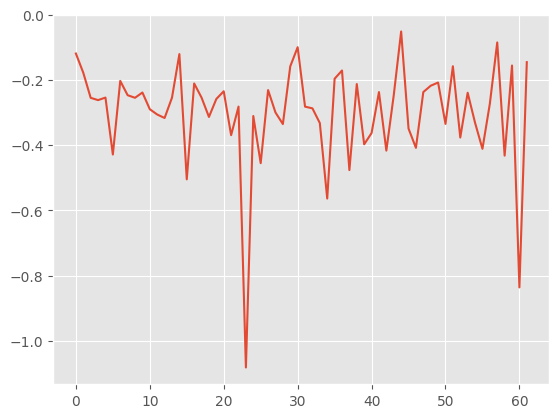

In [30]:
plt.plot(rewards_mean)

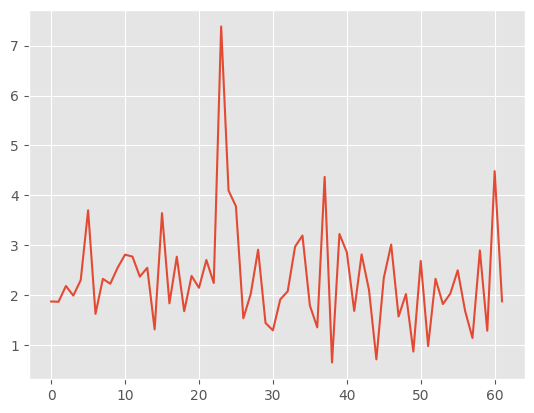

In [31]:
plt.plot(kl_divergence)

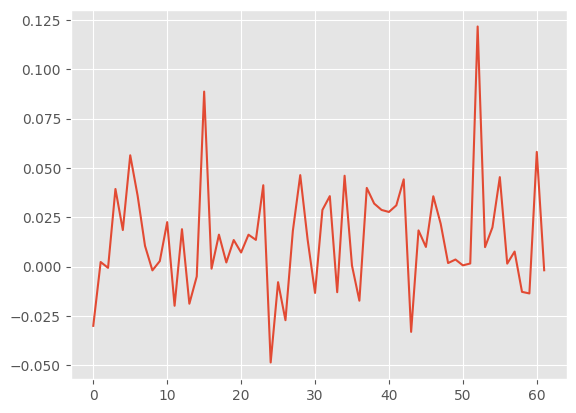

In [32]:
plt.plot(advantages)

In [44]:
peft_model.save_pretrained('/content/drive/MyDrive/ml_data/fine-tuning-llms-rlhf/peft')

## Create Bias baseline

In [34]:
import tqdm

def evaluate(dataset, peft_model, ppo_model):
  df = pd.DataFrame(columns=['context', 'question', 'baseline_answer', 'peft_pred_ans', 'peft_sentiment', 'peft_score', 'ppo_pred_ans', 'ppo_sentiment', 'ppo_score'])
  contexts = []
  questions = []
  answers = []
  peft_pred_answers = []
  ppo_pred_answers = []
  peft_sentiments = []
  ppo_sentiments = []
  peft_sentiment_scores = []
  ppo_sentiment_scores = []
  for i, row in tqdm.tqdm(enumerate(dataset)):
    context = row['context']
    question = row['question']
    answer = row['answers.text'][0]
    inputs = f"""Answer a question about this article:\n{context}\nQ:{question}A:"""
    input_text = tokenizer(inputs,truncation=True,
                           padding="max_length",
                           return_tensors='pt',
                           max_length=target_max_length)['input_ids']

    peft_model = peft_model.to('cpu')
    ppo_model = ppo_model.to('cpu')
    # print(inputs)

    # Get sentiment for peft model
    peft_pred_ans = peft_model.generate(input_ids=input_text)
    peft_output_text =  tokenizer.batch_decode(peft_pred_ans, skip_special_tokens=True)[0]
    peft_sentiment = classifier(peft_output_text, **classifier_probs_kwargs)

    # Get sentiment for PPO Model
    ppo_pred_ans = ppo_model.generate(input_ids=input_text)
    ppo_output_text =  tokenizer.batch_decode(ppo_pred_ans, skip_special_tokens=True)[0]
    ppo_sentiment = classifier(ppo_output_text, **classifier_probs_kwargs)

    contexts.append(context)
    questions.append(question)
    answers.append(answer)
    peft_pred_answers.append(peft_output_text)
    ppo_pred_answers.append(ppo_output_text)
    peft_sentiments.append(get_sentiment(peft_sentiment))
    peft_sentiment_scores.append(get_positive_score(peft_sentiment))
    ppo_sentiments.append(get_sentiment(ppo_sentiment))
    ppo_sentiment_scores.append(get_positive_score(ppo_sentiment))

  df['context'] = contexts
  df['question'] = questions
  df['baseline_answer'] = answers
  df['peft_pred_ans'] = peft_pred_answers
  df['peft_sentiment'] = peft_sentiments
  df['peft_score'] = peft_sentiment_scores
  df['ppo_pred_ans'] = ppo_pred_answers
  df['ppo_sentiment'] = ppo_sentiments
  df['ppo_score'] = ppo_sentiment_scores
  return df

# this is a time taking step,  in 1 min 15 rows are evaluated
df = evaluate(filtered_squad['test'], peft_model, ppo_model)

300it [23:18,  4.66s/it]


In [45]:
df.to_csv('/content/drive/MyDrive/ml_data/fine-tuning-llms-rlhf/evaluation.csv')

## Evaluation

In [41]:
df

,context,question,baseline_answer,peft_pred_ans,peft_sentiment,peft_score,ppo_pred_ans,ppo_sentiment,ppo_score,peft_word_count,ppo_word_count
0,Catalan shares many traits with its neighborin...,"Besides vocabulary and grammar, what other dif...",pronunciation,Cortan,1,0.578823,IB.,1,0.701930,1,1
1,A test given to new students by Stanford Unive...,Where was a test performed to collect data on ...,Stanford University,'Sizzle',1,0.547555,the'sizzle',0,0.416384,1,1
2,"Where there is a distinction, Nasrani refers t...",What description is used for Western people wh...,Nasrani,bald people,0,0.119217,e.g.,1,0.555491,2,1
3,"In 1972, Walter Fiers and his team at the Univ...",Who developed chain termination DNA sequencing...,Frederick Sanger,the system,1,0.549042,The adapest of the genes of the adapest,1,0.697952,2,8
4,"In February 2016, over a hundred thousand peop...",How many people signed a petition to boycott S...,over a hundred thousand,Kristina,1,0.796915,a court of motion,1,0.529131,1,4
...,...,...,...,...,...,...,...,...,...,...,...
295,Paper waste accounts for up to 40% of total wa...,How many paper cups are used by Americans each...,16 billion,16 billion,1,0.569909,71.6 million,1,0.601256,2,2
296,The BBC began its own regular television progr...,Where was the BBC's second studio located?,"16 Portland Place, London",broadcasts,1,0.652058,over the years,1,0.917273,1,3
297,"As of 2000[update], children and teenagers (0–...",What percent of the population are between 20-64?,65%,19.9%,1,0.660763,15.1%,1,0.506008,1,1
298,Just as their customers pay them for Internet ...,Why does an ISP need to pay an upstream ISP?,An upstream ISP usually has a larger network t...,an ISP,1,0.570378,Internet access,1,0.594670,2,2


In [36]:
print("Rouge Metric before PPO")
print(rogue_metric.compute(predictions=df['peft_pred_ans'], references=df['baseline_answer']))
print("==="*20)
print("Rouge Metric after PPO")
print(rogue_metric.compute(predictions=df['ppo_pred_ans'], references=df['baseline_answer']))

Rouge Metric before PPO
{'rouge1': 0.3202990046990048, 'rouge2': 0.15947124453646191, 'rougeL': 0.32178210678210684, 'rougeLsum': 0.3218289340289341}
Rouge Metric after PPO
{'rouge1': 0.3256059958559959, 'rouge2': 0.15144533244533243, 'rougeL': 0.325926554926555, 'rougeLsum': 0.32602218152218165}


In [37]:
print("Number of positive responses before PPO")
print(len(df[df['peft_sentiment'] == 1]))
print("==="*20)
print("Number of positive responses after PPO")
print(len(df[df['ppo_sentiment'] == 1]))

Number of positive responses before PPO
243
Number of positive responses after PPO
226


In [38]:
print("Mean positive score before PPO")
print(df[df['peft_sentiment'] == 1]['peft_score'].mean())
print("Mean positive score before PPO")
print(df[df['ppo_sentiment'] == 1]['ppo_score'].mean())

Mean positive score before PPO
0.6673143057175625
Mean positive score before PPO
0.6689053399372945


In [39]:
df['peft_word_count'] = df['peft_pred_ans'].apply(lambda x: len(x.split()))
df['ppo_word_count'] = df['ppo_pred_ans'].apply(lambda x: len(x.split()))

In [40]:
print("Average Word Count before PPO")
print(df['peft_word_count'].mean())
print("Average Word Count after PPO")
print(df['ppo_word_count'].mean())

Average Word Count before PPO
2.0233333333333334
Average Word Count after PPO
2.296666666666667
